# 第一问（处方一）

In [31]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt #导入所需要的库

class Gena_TSP(object):
    def __init__(self,data,maxgen=300,size_pop=200,cross_prob=0.9,pmuta_prob=0.01,select_prob=0.8):
        self.maxgen = maxgen #最大迭代次数
        self.size_pop = size_pop  #群体个数
        self.cross_prob = cross_prob #交叉概率
        self.pmuta_prob = pmuta_prob #变异概率
        self.select_prob = select_prob #选择概率
        
        self.data = data   #城市的左边数据
        self.num =len(data) #城市个数 对应染色体长度
        
        self.matrix_distance = self.matrix_dis() 
       #距离矩阵n*n, 第[i,j]个元素表示城市i到j距离matrix_dis函数见下文
        
        self.select_num = max(floor(self.size_pop*self.select_prob+0.5),2) 
       #通过选择概率确定子代的选择个数

        self.chrom = np.array([0]*self.size_pop*self.num).reshape(self.size_pop,self.num)
        self.sub_sel = np.array([0]*self.select_num*self.num).reshape(self.select_num,self.num)
        #父代和子代群体的初始化（不直接用np.zeros是为了保证单个染色体的编码为整数，np.zeros对应的数据类型为浮点型）   
        
        self.fitness = np.zeros(self.size_pop)
        #存储群体中每个染色体的路径总长度，对应单个染色体的适应度就是其倒数

        self.best_fit = []
        self.best_path= []
        #保存每一步的群体的最优路径和距离
    def matrix_dis(self):
        res = np.zeros((self.num,self.num))
        for i in range(self.num):
            for j in range(i+1,self.num):
                res[i,j] = np.linalg.norm(self.data[i,:]-self.data[j,:])
                res[j,i] = res[i,j]
        return res
    def rand_chrom(self):
            rand_ch = np.array(range(self.num))
            for i in range(self.size_pop):
                np.random.shuffle(rand_ch)
                self.chrom[i,:]= rand_ch
                self.fitness[i] = self.comp_fit(rand_ch)

    def comp_fit(self, one_path):
        res = 0
        for i in range(self.num-1):
            res += self.matrix_distance[one_path[i],one_path[i+1]]
        res += self.matrix_distance[one_path[-1],one_path[0]]
        return res

    def out_path(self, one_path):
        res = str(one_path[0]+1)+'-->'
        for i in range(1, self.num):
            res += str(one_path[i]+1)+'-->'
        res += str(one_path[0]+1)+'\n'
        print(res)

    def select_sub(self):
        fit = 1./(self.fitness) #适应度函数
        cumsum_fit = np.cumsum(fit)
        pick = cumsum_fit[-1]/self.select_num*(np.random.rand()+np.array(range(self.select_num)))
        i,j = 0,0
        index = []
        while i<self.size_pop and j<self.select_num:
            if cumsum_fit[i]>= pick[j]:
                index.append(i)
                j += 1
            else:
                i += 1
        self.sub_sel = self.chrom[index,:]


    def cross_sub(self):
            if self.select_num%2 == 0:
                num = range(0,self.select_num,2)
            else:
                num = range(0,self.select_num-1,2)
            for i in num:
                if self.cross_prob>=np.random.rand():
                    self.sub_sel[i,:],self.sub_sel[i+1,:] = self.intercross(self.sub_sel[i,:],self.sub_sel[i+1,:])
                    
    def intercross(self,ind_a,ind_b):
                r1 = np.random.randint(self.num)
                r2 = np.random.randint(self.num)
                while r2 == r1:
                    r2 = np.random.randint(self.num)
                left,right = min(r1,r2),max(r1,r2)
                ind_a1 = ind_a.copy()
                ind_b1 = ind_b.copy()
                for i in range(left,right+1):
                    ind_a2 = ind_a.copy()
                    ind_b2 = ind_b.copy()
                    ind_a[i] = ind_b1[i] 
                    ind_b[i] = ind_a1[i]
                    x = np.argwhere(ind_a==ind_a[i])
                    y = np.argwhere(ind_b==ind_b[i])
                    if len(x) == 2:
                        ind_a[x[x!=i]] = ind_a2[i]
                    if len(y) == 2:
                        ind_b[y[y!=i]] = ind_b2[i]
                return ind_a,ind_b
    def mutation_sub(self):
        for i in range(self.select_num):
            if np.random.rand() <= self.cross_prob:
                r1 = np.random.randint(self.num)
                r2 = np.random.randint(self.num)
                while r2 == r1:
                    r2 = np.random.randint(self.num)
                self.sub_sel[i,[r1,r2]] = self.sub_sel[i,[r2,r1]]

    def reverse_sub(self):
        for i in range(self.select_num):
            r1 = np.random.randint(self.num)
            r2 = np.random.randint(self.num)
            while r2 == r1:
                r2 = np.random.randint(self.num)
            left,right = min(r1,r2),max(r1,r2)
            sel = self.sub_sel[i,:].copy()
            
            sel[left:right+1] = self.sub_sel[i,left:right+1][::-1]
            if self.comp_fit(sel) < self.comp_fit(self.sub_sel[i,:]):
                self.sub_sel[i,:] = sel

    def reins(self):
        index = np.argsort(self.fitness)[::-1]
        self.chrom[index[:self.select_num],:] = self.sub_sel



def main(data):
    Path_short = Gena_TSP(data) #根据位置坐标，生成一个遗传算法类
    Path_short.rand_chrom()  #初始化父类

    

    #循环迭代遗传过程
    for i in range(Path_short.maxgen):
        Path_short.select_sub()   #选择子代
        Path_short.cross_sub()    #交叉
        Path_short.mutation_sub() #变异
        Path_short.reverse_sub()  #进化逆转
        Path_short.reins()        #子代插入

        #重新计算新群体的距离值
        for j in range(Path_short.size_pop):
            Path_short.fitness[j] = Path_short.comp_fit(Path_short.chrom[j,:])
         
        #每隔一百步显示当前群体的最优路径
        index = Path_short.fitness.argmin()
        if (i+1)%100 == 0:
            print('第'+str(i+1)+'步后的最短的路程: '+str( Path_short.fitness[index]))
            print('第'+str(i+1)+'步后的最优路径:')
            Path_short.out_path(Path_short.chrom[index,:])# 显示每一步的最优路径
        
        #存储每一步的最优路径及距离
        Path_short.best_fit.append(Path_short.fitness[index])
        Path_short.best_path.append(Path_short.chrom[index,:])
    
    ## 绘制初始化的路径图
    fig,ax=plt.subplots()
    x = data[:,0]
    y = data[:,1]
    plt.xlim(0,300)
    plt.ylim(0,200)
    plt.xticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
    plt.yticks([0,25,50,75,100,125,150,175,200,225,250,275,300])
    ax.scatter(x, y,linewidths=0.1)
    for i,txt in enumerate(range(1,len(data)+1)):
        ax.annotate(txt,(x[i],y[i]))
    res0 = Path_short.chrom[0]
    x0 = x[res0]
    y0 = y[res0]
    for i in range(len(data)-1):
        plt.quiver(x0[i], y0[i],x0[i+1]-x0[i], y0[i+1]-y0[i], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')  
    plt.quiver(x0[-1], y0[-1],x0[0]-x0[-1], y0[0]-y0[-1], color='r', width=0.005,angles='xy',scale=1, scale_units='xy')
    plt.grid()
    plt.show()
    # print('初始染色体的路程: '+str( Path_short.fitness[0]))
    return Path_short  #返回遗传算法结果类


In [32]:

data = np.array([10,135.5,30,112.5,30,87.5,
    50,112.5,50,87.5,50,37.5,110,67.5,
    190,67.5,190,162.5,190,187.5]).reshape(10,2)

为什么上面只有10个点？因为既然打开了某个柜子，而这个柜子里有不止一种我们要的药材，那我肯定一起都拿出来了

第100步后的最短的路程: 597.5264303561733
第100步后的最优路径:
6-->5-->3-->2-->1-->4-->10-->9-->8-->7-->6

第200步后的最短的路程: 597.5264303561733
第200步后的最优路径:
7-->6-->5-->3-->2-->1-->4-->10-->9-->8-->7

第300步后的最短的路程: 597.5264303561733
第300步后的最优路径:
7-->6-->5-->3-->2-->1-->4-->10-->9-->8-->7



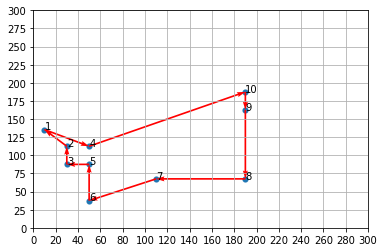

In [33]:
main(data)